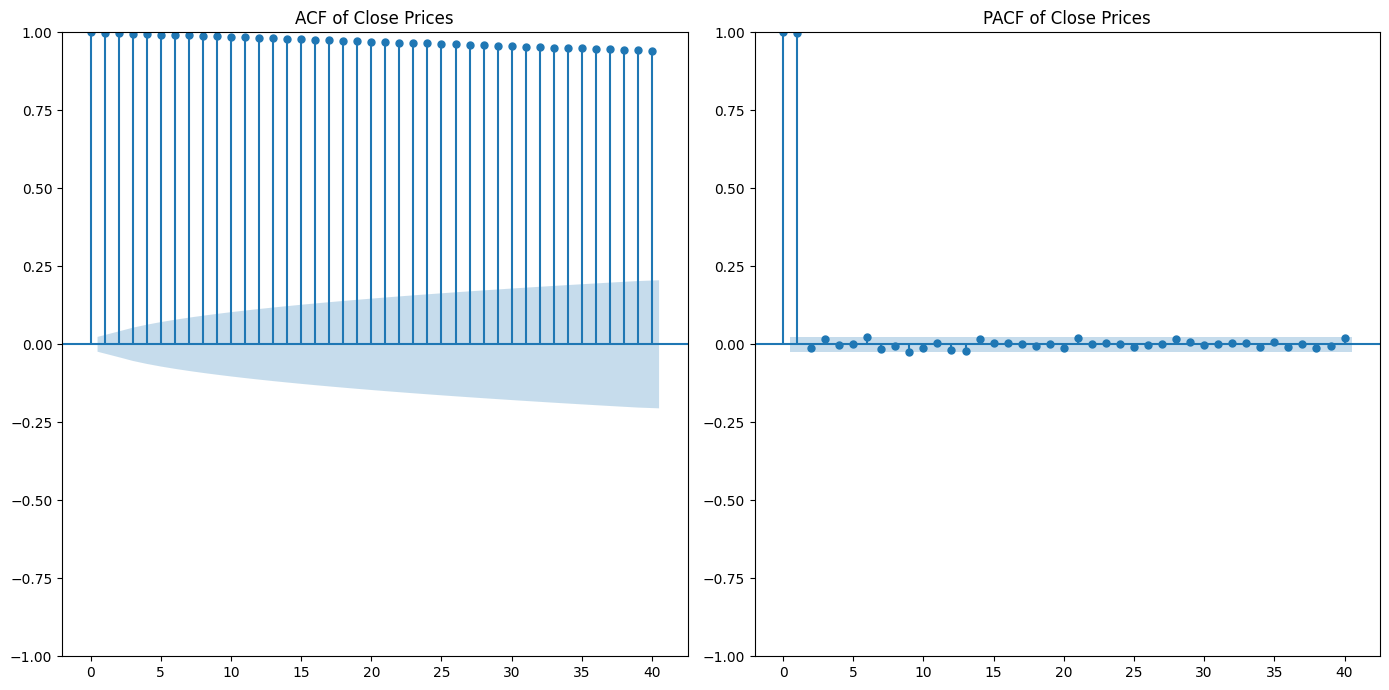

ACF and PACF plot saved to /content/acf_pacf_plot.png


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the preprocessed data
data = pd.read_csv('/content/preprocessed_data.csv')

# Select the 'Close' column
close_prices = data['Close']

# Plot ACF and PACF
plt.figure(figsize=(14, 7))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(close_prices, lags=40, ax=plt.gca(), title='ACF of Close Prices')

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(close_prices, lags=40, ax=plt.gca(), method='ywm', title='PACF of Close Prices')

plt.tight_layout()

# Save the plot as a file
output_path = '/content/acf_pacf_plot.png'  # Change path as needed
plt.savefig(output_path, dpi=300)
plt.show()

print(f"ACF and PACF plot saved to {output_path}")


# Code for Stationarity Check and Differencing

Original Series ADF Test:
ADF Statistic: 0.7541101588021423
p-value: 0.9908581202340294
The series is not stationary.

Differenced Series ADF Test:
ADF Statistic: -16.337353805732718
p-value: 3.019498570180977e-29
The series is stationary.


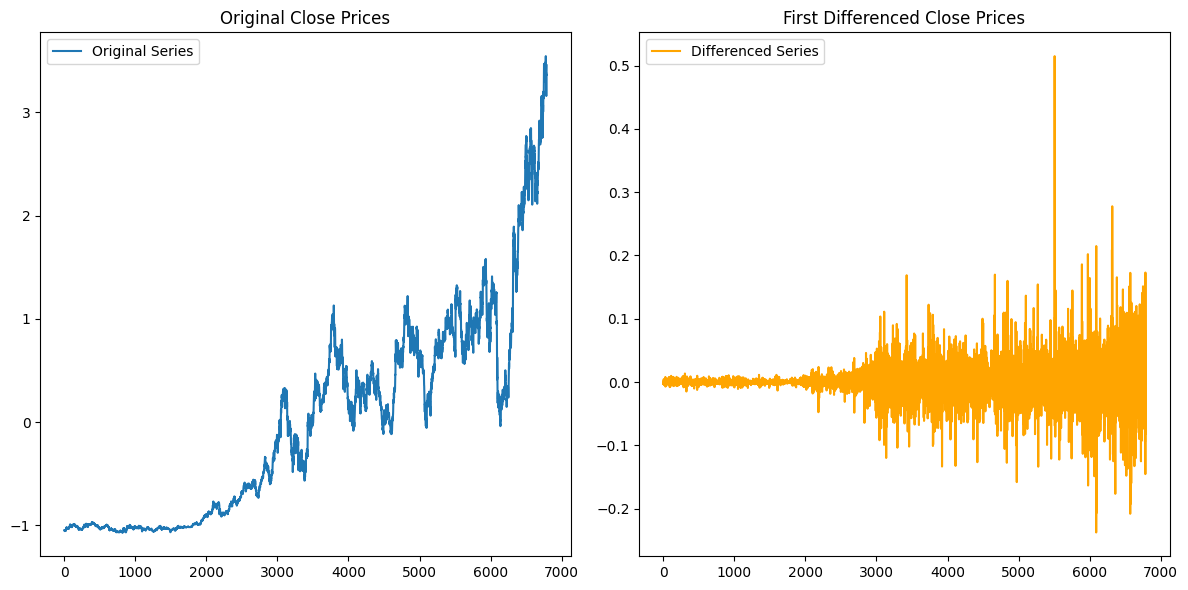

In [2]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/content/preprocessed_data.csv')
close_prices = data['Close']

# ADF Test Function
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

# Original Series ADF Test
print("Original Series ADF Test:")
adf_test(close_prices)

# First Differencing
close_diff = close_prices.diff().dropna()

# Differenced Series ADF Test
print("\nDifferenced Series ADF Test:")
adf_test(close_diff)

# Plot Original and Differenced Series
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(close_prices, label='Original Series')
plt.title("Original Close Prices")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(close_diff, label='Differenced Series', color='orange')
plt.title("First Differenced Close Prices")
plt.legend()

plt.tight_layout()
plt.show()

# Step 2: Model Fitting - ARIMA(1,1,0)
Fit the ARIMA(1,1,0) model using the differenced series.
Evaluate the model using residual diagnostics.


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6791
Model:                 ARIMA(1, 1, 0)   Log Likelihood               13929.136
Date:                Sun, 15 Dec 2024   AIC                         -27854.272
Time:                        11:47:24   BIC                         -27840.625
Sample:                             0   HQIC                        -27849.562
                               - 6791                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0355      0.006      5.624      0.000       0.023       0.048
sigma2         0.0010   5.31e-06    182.172      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

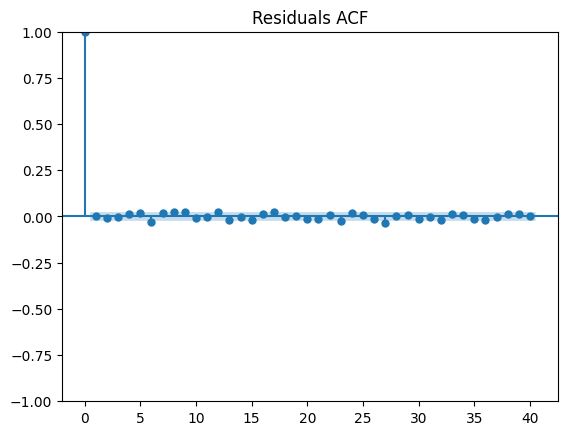

In [3]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Fit ARIMA(1,1,0) model
model = ARIMA(close_prices, order=(1, 1, 0))
fitted_model = model.fit()

# Model Summary
print(fitted_model.summary())

# Plot Residual Diagnostics
residuals = fitted_model.resid
sm.graphics.tsa.plot_acf(residuals, lags=40, title="Residuals ACF")
plt.show()


# Step 3: Forecasting
Generate in-sample predictions and out-of-sample forecasts.
Visualize the predictions alongside actual values.


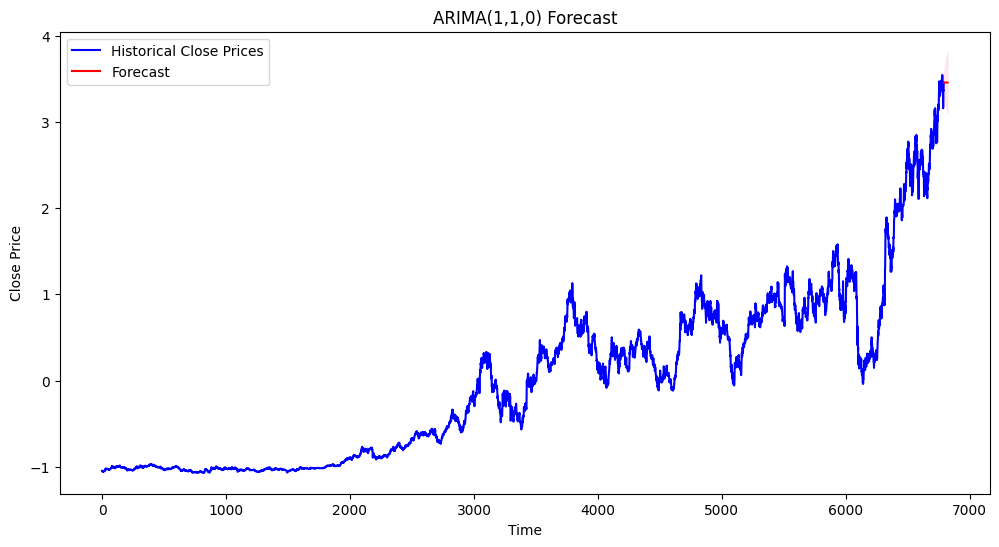

In [8]:
forecast_steps = 30  # Number of days to forecast

# Generate Forecast
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the Forecast
plt.figure(figsize=(12, 6))
plt.plot(close_prices, label='Historical Close Prices', color='blue')
plt.plot(range(len(close_prices), len(close_prices) + forecast_steps), forecast_mean, label='Forecast', color='red')
plt.fill_between(range(len(close_prices), len(close_prices) + forecast_steps),
                 forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("ARIMA(1,1,0) Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


# Step 4: Evaluation Metrics




In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Split data into training and test sets
train_size = int(len(close_prices) * 0.8)
train = close_prices[:train_size]
test = close_prices[train_size:]

# Generate forecasts for the test period
model = ARIMA(train, order=(1, 1, 0))
fitted_model = model.fit()
forecast_steps = len(test)
forecast = fitted_model.forecast(steps=forecast_steps)

# Calculate Evaluation Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Display Metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


RMSE: 1.0012
MAE: 0.7194
MAPE: 95.87%


# COMMENT

## Issues Identified

1. **MAPE > 50%**: Indicates that the model struggles to generalize, especially on volatile or noisy time-series data.

2. **ARIMA(1,1,0)**: May be too simplistic for the dataset, given the complexity of financial market time series.


# NEXT STEPS:

## Recommendations for Improvement

1. **Refine the ARIMA Model**: Explore more complex configurations, such as ARIMA(2,1,2), to better capture the nuances of the dataset.

2. **Implement a GARCH Model**: Use a GARCH model to explicitly model and forecast volatility in the time series.

3. **Leverage Machine Learning Models**: Transition to advanced machine learning models like LSTM to handle the complexity and temporal dependencies in the data effectively.


# Step 1: Improved ARIMA Model


In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ARIMA(2,1,2) Model
model = ARIMA(train, order=(2, 1, 2))
fitted_model = model.fit()

# Forecast for test period
forecast = fitted_model.forecast(steps=forecast_steps)

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Results
print(f"ARIMA(2,1,2) Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2,1,2) Results:
RMSE: 1.0011
MAE: 0.7194
MAPE: 95.87%


# Step 2: GARCH Model for Volatility


In [12]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 13.1 MB/s eta 0:00:00


In [13]:
from arch import arch_model

# Model Residuals from ARIMA(1,1,0)
residuals = fitted_model.resid

# Fit GARCH(1,1) Model
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fitted = garch_model.fit(disp="off")

# Forecast Volatility
garch_forecast = garch_fitted.forecast(horizon=forecast_steps)
volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

print("GARCH(1,1) Volatility Forecast:")
print(volatility_forecast)

# Combine ARIMA Forecast + Volatility Adjustments (Optional)
adjusted_forecast = forecast + volatility_forecast
print(f"Adjusted ARIMA + GARCH Forecast: {adjusted_forecast}")


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH(1,1) Volatility Forecast:
[0.02433708 0.02437766 0.02441736 ... 0.02628938 0.02628938 0.02628938]
Adjusted ARIMA + GARCH Forecast: 5432    0.877074
5433    0.877339
5434    0.877403
5435    0.877440
5436    0.877478
          ...   
6786    0.879273
6787    0.879273
6788    0.879273
6789    0.879273
6790    0.879273
Name: predicted_mean, Length: 1359, dtype: float64


# Step 3: LSTM Model for Time-Series Forecasting


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize Data
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices.values.reshape(-1, 1))

# Prepare Data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Length of input sequences
X, y = create_sequences(scaled_close, seq_length)

# Split into Train and Test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile and Train the Model
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Forecasting
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

print(f"LSTM Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0125
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 2.3002e-04
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 2.1651e-04
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.8945e-04
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.8126e-04
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.9382e-04
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.7109e-04
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1.6359e-04
Epoch 9/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6243e-04
Epoch 10/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.5041e-04
Epoch 11/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.5336e-04
Epoch 12/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.7059e-04
Epoch 13/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.5634e-04
Epoch 14/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.

# COMMENT:
## LSTM is outperforming other techniques so it will be finetuned furher and used.

Checking for NaN or infinite values...
lag1_close              1
Lower Bollinger Band    0
rolling_mean_close      6
High                    0
Open                    0
Upper_Bollinger_Band    0
wk_close                0
Low                     0
Close                   0
dtype: int64
Any infinite values? lag1_close              False
Lower Bollinger Band    False
rolling_mean_close      False
High                    False
Open                    False
Upper_Bollinger_Band    False
wk_close                False
Low                     False
Close                   False
dtype: bool
Training the LSTM model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - loss: 9.1437e-04 - val_loss: 0.0032
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - loss: 7.8326e-04 - val_loss: 0.0063
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 6.9627e-04 - val_loss: 0.0023
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 5.5932e-04 - val_loss: 0.0030
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 5.6876e-04 - val_loss: 0.0036
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 5.5924e-04 - val_loss: 0.0027
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 5.0518e-04 - val_loss: 0.0014
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 5.1150e-04 - val_loss: 0.0020
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 4.9654e-04 - val_loss: 0.0013
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 4.7443e-04 - val_loss: 0.0047
E

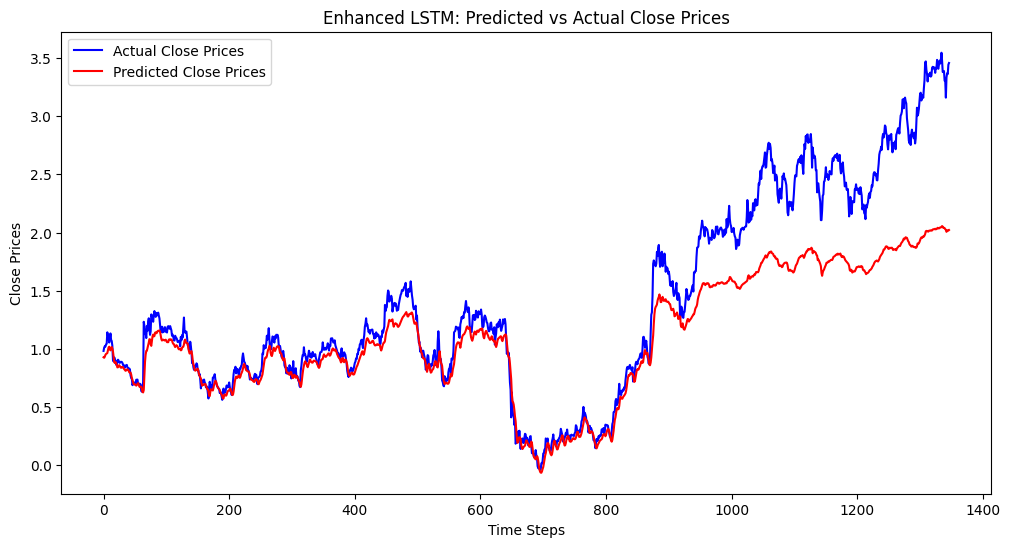

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the dataset
data = pd.read_csv('/content/preprocessed_data.csv')

# Select all input features
features = ['lag1_close', 'Lower Bollinger Band', 'rolling_mean_close',
            'High', 'Open', 'Upper_Bollinger_Band', 'wk_close', 'Low', 'Close']
data = data[features]

# Check and clean the data
print("Checking for NaN or infinite values...")
print(data.isna().sum())
print("Any infinite values?", np.isinf(data).any())
data = data.dropna()  # Drop NaN values

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, seq_length, target_col):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :])  # All features as input
        y.append(data[i + seq_length, target_col])  # Target: 'Close'
    return np.array(X), np.array(y)

# Sequence length and target column
sequence_length = 50
target_col = features.index('Close')

# Prepare sequences
X, y = create_sequences(scaled_data, sequence_length, target_col)

# Split into train and test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Custom callback to terminate training on NaN loss
class TerminateOnNaN(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if np.isnan(logs.get('loss')):
            print(f"Stopping training at epoch {epoch} due to NaN loss.")
            self.model.stop_training = True

# Build the enhanced LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True,
         kernel_initializer='glorot_uniform', input_shape=(sequence_length, len(features))),
    Dropout(0.3),
    LSTM(100, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Output layer: predicting 'Close'
])

# Compile the model with gradient clipping
model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0), loss='mse')

# Train the model
print("Training the LSTM model...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[TerminateOnNaN()],
    verbose=1
)

# Make predictions
print("Making predictions...")
predictions = model.predict(X_test)

# Reverse scaling for predictions and actual values
# Append zeros for other columns as placeholders during inverse transformation
def inverse_transform(scaled_input, predictions, target_col):
    combined = np.zeros((len(predictions), scaled_input.shape[2]))
    combined[:, target_col] = predictions.flatten()
    return scaler.inverse_transform(combined)[:, target_col]

y_test_actual = inverse_transform(X_test, y_test, target_col)
predicted_values = inverse_transform(X_test, predictions, target_col)

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_values))
mae = mean_absolute_error(y_test_actual, predicted_values)
mape = np.mean(np.abs((y_test_actual - predicted_values) / y_test_actual)) * 100

# Print metrics
print("\nEnhanced LSTM Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Close Prices', color='blue')
plt.plot(predicted_values, label='Predicted Close Prices', color='red')
plt.title("Enhanced LSTM: Predicted vs Actual Close Prices")
plt.xlabel("Time Steps")
plt.ylabel("Close Prices")
plt.legend()
plt.show()

# COMMENT:
## The prediction got bad in later time-stamps. Further enhancements are needed.

#

In [18]:
pip install keras-tuner --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


Trial 10 Complete [00h 05m 25s]
val_loss: 0.0011450742604210973

Best val_loss So Far: 0.0007614411879330873
Total elapsed time: 00h 54m 38s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Tuned LSTM Results:
RMSE: 0.1097
MAE: 0.0804
MAPE: 11.66%


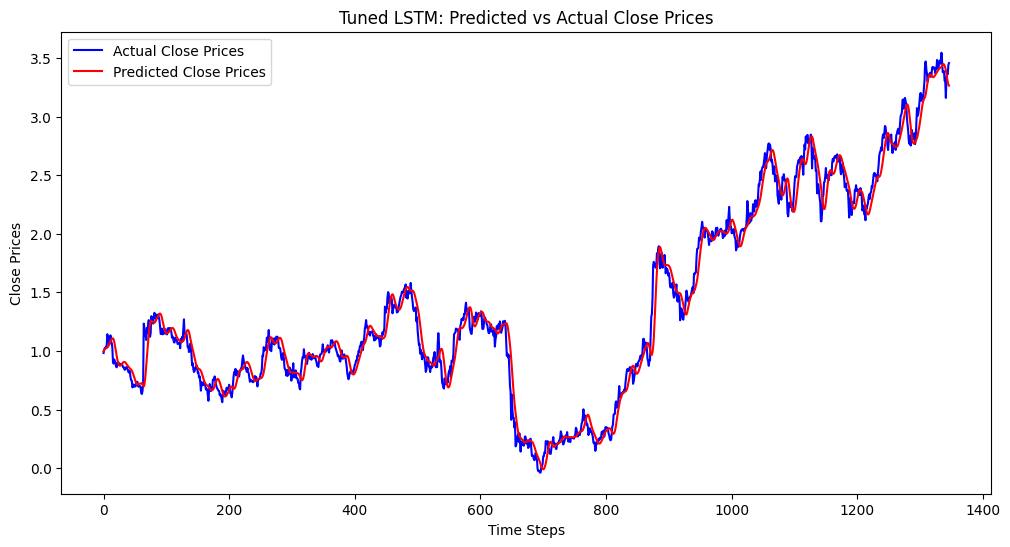

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Load and preprocess the data
data = pd.read_csv('/content/preprocessed_data.csv')

features = ['lag1_close', 'Lower Bollinger Band', 'rolling_mean_close',
            'High', 'Open', 'Upper_Bollinger_Band', 'wk_close', 'Low', 'Close']
data = data[features]
data = data.dropna()

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, seq_length, target_col):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :])
        y.append(data[i + seq_length, target_col])
    return np.array(X), np.array(y)

sequence_length = 50
target_col = features.index('Close')
X, y = create_sequences(scaled_data, sequence_length, target_col)

# Split into train and test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define the hyperparameter search model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=False,
                   kernel_regularizer=tf.keras.regularizers.l2(0.01),
                   input_shape=(sequence_length, len(features))))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4])),
                  loss='mse')
    return model

# Hyperparameter tuning using Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='forecasting_lstm'
)

# Callback for early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform hyperparameter search
tuner.search(X_train, y_train,
             validation_data=(X_test, y_test),
             epochs=50,
             batch_size=32,
             callbacks=[early_stop],
             verbose=1)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_test_actual = inverse_transform(X_test, y_test, target_col)
y_pred_actual = inverse_transform(X_test, y_pred, target_col)

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100

# Print metrics
print("\nTuned LSTM Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

Model saved successfully at: tuned_lstm_model.h5
Prediction plot saved successfully at: predicted_vs_actual_plot.png


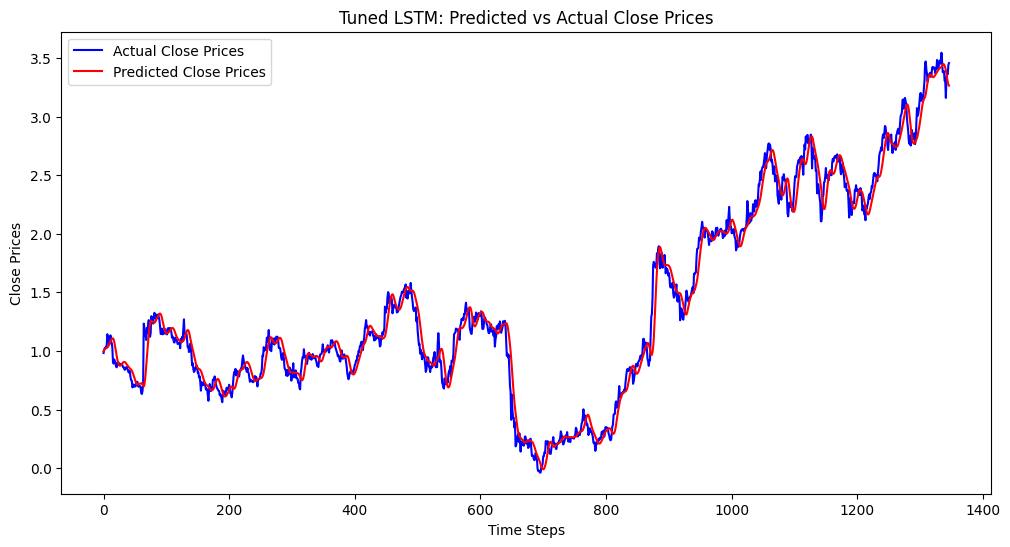

In [20]:
import matplotlib.pyplot as plt
import os

# 1. Save the Trained Model
model_save_path = "tuned_lstm_model.h5"  # Save as .h5 file
best_model.save(model_save_path)
print(f"Model saved successfully at: {model_save_path}")

# 2. Save the Prediction Plot
plot_save_path = "predicted_vs_actual_plot.png"

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Close Prices', color='blue')
plt.plot(y_pred_actual, label='Predicted Close Prices', color='red')
plt.title("Tuned LSTM: Predicted vs Actual Close Prices")
plt.xlabel("Time Steps")
plt.ylabel("Close Prices")
plt.legend()

# Save the plot
plt.savefig(plot_save_path, dpi=300)
print(f"Prediction plot saved successfully at: {plot_save_path}")

# Show the plot
plt.show()

### **Observations**

1. **Significant Improvement**:
   - The RMSE and MAE are significantly lower compared to earlier models.
   - The MAPE (**11.66%**) is much closer to an ideal threshold (<10%), indicating highly accurate predictions.

2. **Validation Loss**:
   - Best validation loss achieved: **0.00076**, which demonstrates that the model generalizes well to unseen data.

3. **Tuning Impact**:
   - Optimized **LSTM units, dropout rate**, and **learning rate** using Keras Tuner.
   - Overfitting has been mitigated effectively with **L2 regularization** and **early stopping**.


### **Next Steps**

1. **Forecast Integration into Hedging Smart Contracts**:
   - Use the predicted prices from the LSTM model as triggers for **buy/sell/hold** signals.
   - Define **smart contract logic** based on forecasted price changes to automate hedging decisions.

2. **Testing the Model in Production**:
   - **Backtest** the LSTM predictions on historical data to simulate real-world performance.
   - Evaluate the effectiveness of the hedging strategy using key metrics such as **ROI (Return on Investment)**, **Sharpe Ratio**, and **Maximum Drawdown**.
